In [8]:
import tarfile
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt
import os 

In [9]:
def untar_brats(path):
    tar = tarfile.open(path)
    tar.extractall('../data/raw/train')
    tar.close()

def load_all_levels(path):
    levels = ['t1','flair','t2','t1ce']
    images = []
    for el in os.listdir(path)[0:10]:
        try:
            images.append([[nib.load(os.path.join(path,el,el +'_'+level+'.nii.gz')).get_fdata() for level in levels],
                nib.load(os.path.join(path,el, el +'_seg.nii.gz')).get_fdata()])
        except:
            pass

    return images



In [10]:
# Run only if not extracted
# untar_brats('../data/raw/BraTS2021_Training_Data.tar')

In [11]:
train_path = '../data/raw/train'
images = load_all_levels(train_path)

# Sections

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


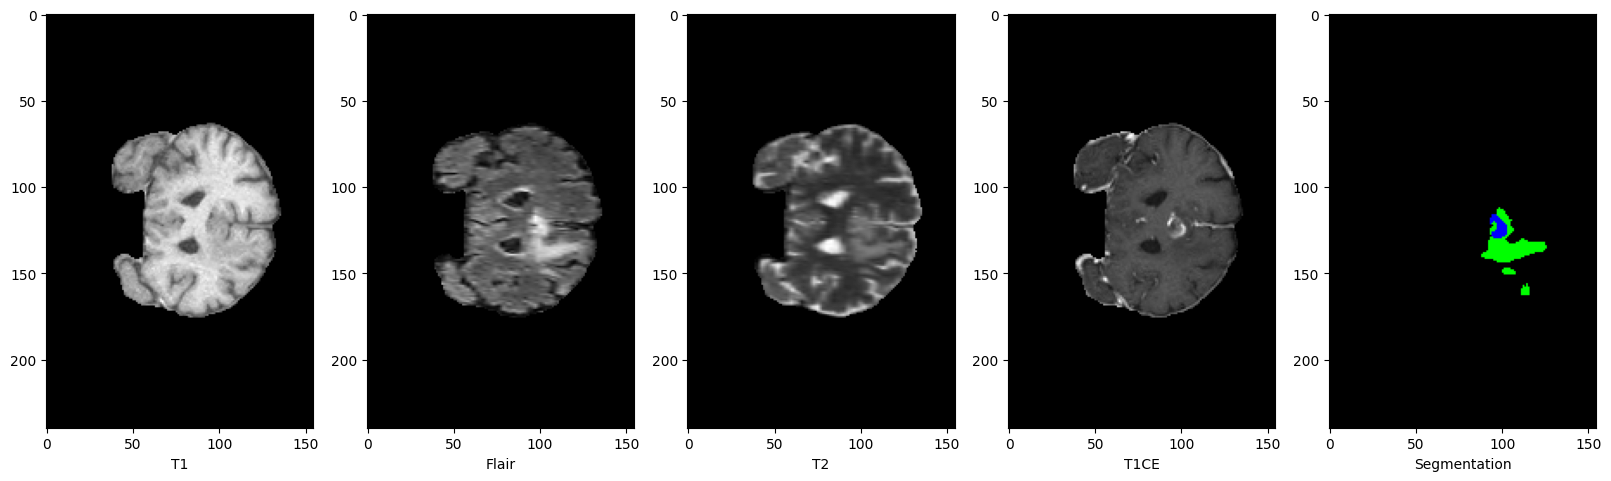

In [12]:
slice_index = 90
n_index = 7
ax = 1
""" 
slice_index = 130
n_index = 4
ax = 1 

slice_index = 50
n_index = 4
ax = 2
"""

d1,d2,d3 = images[n_index][1].shape
dims = [d1,d2,d3]
dims.pop(ax)
color_segmentation = np.zeros((dims[0],dims[1],3))


gray_segmentation = np.take(images[n_index][1],slice_index,axis = ax)
color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
color_segmentation[gray_segmentation == 4] = [0,0,255] # Blue (enhancing tumor)

t1 = np.take(images[n_index][0][0],slice_index,axis = ax)
flair = np.take(images[n_index][0][1],slice_index,axis = ax)
t2 = np.take(images[n_index][0][2],slice_index,axis = ax)
t1ce = np.take(images[n_index][0][3],slice_index,axis = ax)

plt.figure(figsize=(20,10))
plt.subplot(1,5,1)
plt.imshow(t1,cmap='gray')
plt.xlabel('T1')
plt.subplot(1,5,2)
plt.imshow(flair,cmap='gray')
plt.xlabel('Flair')
plt.subplot(1,5,3)
plt.imshow(t2,cmap='gray')
plt.xlabel('T2')
plt.subplot(1,5,4)
plt.imshow(t1ce,cmap='gray')
plt.xlabel('T1CE')
plt.subplot(1,5,5)
plt.imshow(color_segmentation,cmap='gray')
plt.xlabel('Segmentation')
plt.show()

# Image histogram

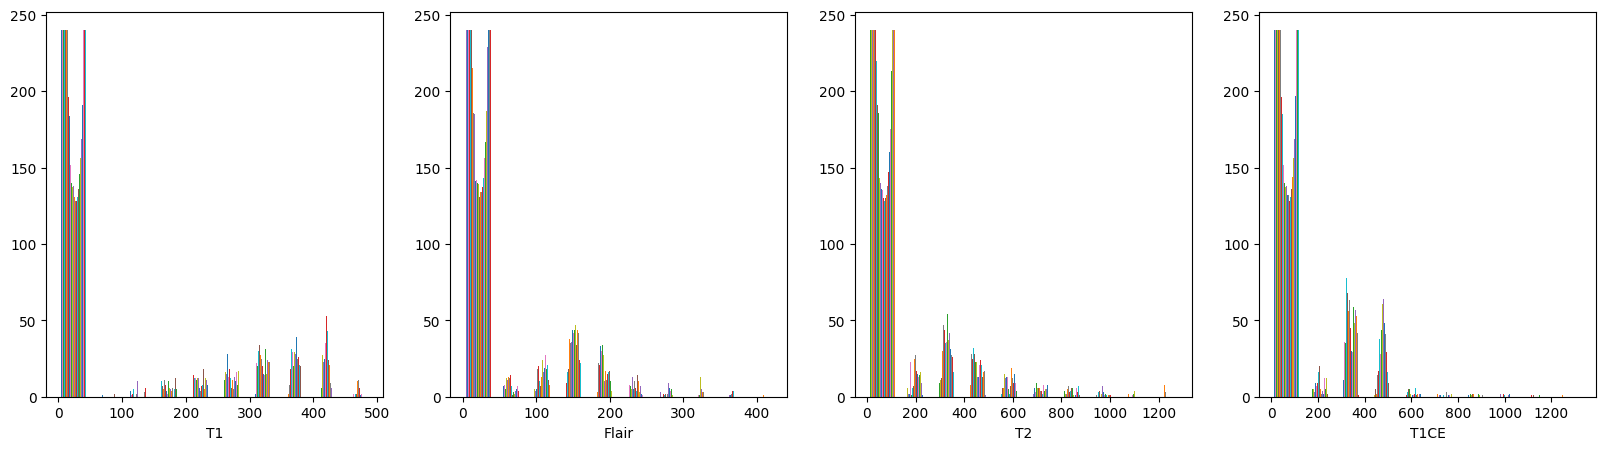

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.hist(t1)
plt.xlabel('T1')
plt.subplot(1,4,2)
plt.hist(flair)
plt.xlabel('Flair')
plt.subplot(1,4,3)
plt.hist(t2)
plt.xlabel('T2')
plt.subplot(1,4,4)
plt.hist(t1ce)
plt.xlabel('T1CE')
plt.show()